# 10 階層ベイズモデル -GLMMのベイズモデル化-

In [21]:
using CSV
using DataFrames
using Distributions
using ForneyLab
using Mamba
using Plots
using QuadGK
using StatsBase
using StatsFuns

## 10.1 例題 : 個体差と生存種子数 (個体差あり)

In [2]:
df = CSV.read("data/section10a.csv")
disallowmissing!(df)

,id,y
,Int64,Int64
1,1,0
2,2,2
3,3,7
4,4,8
5,5,1
6,6,7
7,7,8
8,8,8
9,9,1


青丸は観測データ, 白丸は生存確率0.504の二項分布. 二項分布では観測データのばらつきが説明できていない

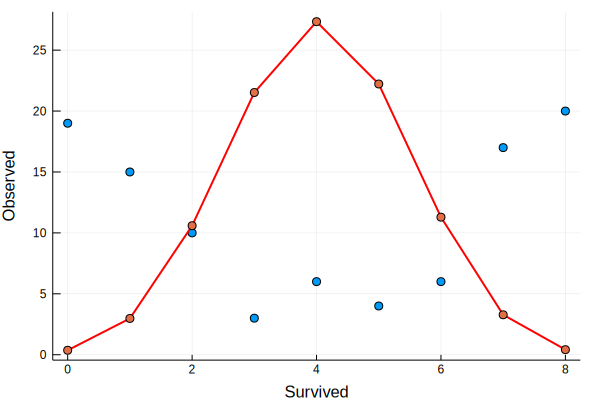

In [3]:
scatter(sort(unique(df.y)), counts(df.y), label = "")
ys = pdf.(Binomial(8, 0.504), 0:8) .* 100
plot!(0:8, ys, linecolor = :red, linewidth = 2,
    marker = 4, label = "",
    xlabel = "Survived", ylabel = "Observed")

## 10.3 階層ベイズモデルの推定・予測
### 10.3.1 階層ベイズモデルのMCMCサンプリング
### モデルの作成

In [4]:
model = Model(
    y = Stochastic(1,
        (beta, r, N) ->
            UnivariateDistribution[
                (q = invlogit(beta + r[i]);
                Binomial(8, q)) for i in 1:N
            ],
        false
    ),
    
    beta = Stochastic(() -> Normal(0, 100)),
    
    r = Stochastic(1,
        (s, N) -> 
            UnivariateDistribution[
                Normal(0, s) for i in 1:N
            ],
        false
    ),
    
    s = Stochastic(() -> Uniform(0, 10000)),
)

Object of type "Model"
-------------------------------------------------------------------------------
beta:
A monitored node of type "ScalarStochastic"
NaN
-------------------------------------------------------------------------------
y:
An unmonitored node of type "0-element ArrayStochastic{1}"
Float64[]
-------------------------------------------------------------------------------
s:
A monitored node of type "ScalarStochastic"
NaN
-------------------------------------------------------------------------------
r:
An unmonitored node of type "0-element ArrayStochastic{1}"
Float64[]


### モデルの図示

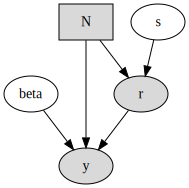

In [5]:
display("image/svg+xml", ForneyLab.dot2svg(graph2dot(model)))

### データの設定

In [6]:
data = Dict{Symbol, Any}(
    :y => df.y,
    :N => length(df.y),
)

Dict{Symbol,Any} with 2 entries:
  :N => 100
  :y => [0, 2, 7, 8, 1, 7, 8, 8, 1, 1  …  6, 2, 8, 6, 6, 1, 0, 4, 7, 0]

### 初期値の設定

In [7]:
inits = [
    Dict{Symbol, Any}(
        :y => df.y,
        :beta => 0.0,
        :r => rand(Normal(0, 0.1), length(df.y)),
        :s => 1.0,
    ) for i in 1:3
]

3-element Array{Dict{Symbol,Any},1}:
 Dict(:beta=>0.0,:y=>[0, 2, 7, 8, 1, 7, 8, 8, 1, 1  …  6, 2, 8, 6, 6, 1, 0, 4, 7, 0],:s=>1.0,:r=>[-0.0662716, 0.250385, -0.039965, 0.0228868, 0.16585, 0.0127141, 0.0741824, 0.00972347, 0.0563386, -0.0196462  …  -0.119557, 0.00406201, -0.136202, -0.0161684, -0.150035, 0.0304298, 0.100082, -0.0519053, -0.0562052, -0.00854644])  
 Dict(:beta=>0.0,:y=>[0, 2, 7, 8, 1, 7, 8, 8, 1, 1  …  6, 2, 8, 6, 6, 1, 0, 4, 7, 0],:s=>1.0,:r=>[-0.0717871, 0.0240372, -0.0563723, -0.0443642, -0.130769, -0.0791706, -0.0447164, -0.0790862, -0.0180228, 0.0580576  …  -0.0919707, 0.0504804, 0.135947, 0.0429359, 0.0507411, 0.0637533, 0.157593, -0.0132283, -0.16204, -0.0100774])
 Dict(:beta=>0.0,:y=>[0, 2, 7, 8, 1, 7, 8, 8, 1, 1  …  6, 2, 8, 6, 6, 1, 0, 4, 7, 0],:s=>1.0,:r=>[0.0162175, -0.169384, -0.101043, -0.115228, 0.207777, 0.0604609, 0.0401059, 0.0469873, 0.0466515, 0.0221096  …  0.0247378, -0.0328841, 0.0244975, -0.0218975, -0.0741526, 0.0285103, -0.0754743, -0.155415, 0.0

### MCMCサンプル方法の設定
NUTSを使うと遅くなってしまったので、AMWGを使用

In [8]:
scheme = [
    Slice(:s, 1.0, Mamba.Univariate),
    Slice(:beta, 1.0, Mamba.Univariate),
    AMWG(:r, 1),
]

3-element Array{Sampler,1}:
 An object of type "Sampler{Mamba.SliceTune{Distributions.Univariate}}"
Sampling Block Nodes:
Symbol[:s]

CodeInfo(
1 ─ %1 = π (##287#289{Bool,Float64}(false, 1.0), Const(##287#289{Bool,Float64}(false, 1.0), false))
│   %2 = (%1)(model, block)::Any
└──      return %2
) => Any
                                                                                                                                                                                                                           
 An object of type "Sampler{Mamba.SliceTune{Distributions.Univariate}}"
Sampling Block Nodes:
Symbol[:beta]

CodeInfo(
1 ─ %1 = π (##287#289{Bool,Float64}(false, 1.0), Const(##287#289{Bool,Float64}(false, 1.0), false))
│   %2 = (%1)(model, block)::Any
└──      return %2
) => Any
                                                                                                                                                                                                   

### MCMCサンプリング
サンプリングは20000回実施し, burn-inの数は1000, 10飛ばしの結果の記録を3チェイン行うので、サンプルの数は(20000-1000)/10*3=5700個

In [9]:
setsamplers!(model, scheme)
sim = mcmc(model, data, inits, 20000, burnin = 1000, thin = 10, chains = 3)

MCMC Simulation of 20000 Iterations x 3 Chains...

Chain 1:   0% [0:41:29 of 0:41:30 remaining]
Chain 1:  10% [0:02:06 of 0:02:20 remaining]
Chain 1:  20% [0:01:59 of 0:02:28 remaining]
Chain 1:  30% [0:01:35 of 0:02:16 remaining]
Chain 1:  40% [0:01:17 of 0:02:09 remaining]
Chain 1:  50% [0:01:03 of 0:02:05 remaining]
Chain 1:  60% [0:00:49 of 0:02:03 remaining]
Chain 1:  70% [0:00:36 of 0:02:01 remaining]
Chain 1:  80% [0:00:24 of 0:01:59 remaining]
Chain 1:  90% [0:00:12 of 0:01:58 remaining]
Chain 1: 100% [0:00:00 of 0:01:58 remaining]

Chain 2:   0% [0:01:50 of 0:01:50 remaining]
Chain 2:  10% [0:01:38 of 0:01:48 remaining]
Chain 2:  20% [0:01:27 of 0:01:49 remaining]
Chain 2:  30% [0:01:16 of 0:01:49 remaining]
Chain 2:  40% [0:01:11 of 0:01:58 remaining]
Chain 2:  50% [0:00:58 of 0:01:57 remaining]
Chain 2:  60% [0:00:46 of 0:01:56 remaining]
Chain 2:  70% [0:00:34 of 0:01:55 remaining]
Chain 2:  80% [0:00:23 of 0:01:54 remaining]
Chain 2:  90% [0:00:12 of 0:01:56 remaining]
Cha

Object of type "ModelChains"

Iterations = 1010:20000
Thinning interval = 10
Chains = 1,2,3
Samples per chain = 1900

[2.81264 -0.172821; 3.21211 0.123255; … ; 3.06609 0.476483; 2.9019 0.235784]

[2.73711 0.424341; 2.48746 0.464484; … ; 3.01855 0.516834; 3.35543 0.639509]

[2.79551 -0.258379; 3.24836 -0.357435; … ; 2.73561 0.0798543; 2.55292 0.492253]

### サンプリング結果を表示

In [10]:
describe(sim)

Iterations = 1010:20000
Thinning interval = 10
Chains = 1,2,3
Samples per chain = 1900

Empirical Posterior Estimates:
         Mean        SD       Naive SE      MCSE       ESS   
   s 3.044845910 0.36990520 0.004899514 0.008443623 1900.0000
beta 0.054174175 0.34492256 0.004568611 0.012350720  779.9355

Quantiles:
        2.5%       25.0%       50.0%      75.0%      97.5%  
   s  2.4128816  2.78246692 3.012634513 3.2793174 3.86331004
beta -0.6393282 -0.16803995 0.052207155 0.2801482 0.72783021



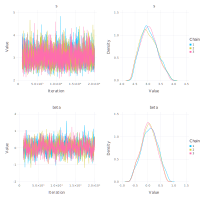

In [11]:
p = Mamba.plot(sim, legend = true)
Mamba.draw(p, nrow = 2, ncol = 2)

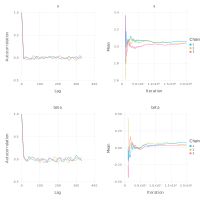

In [12]:
p = Mamba.plot(sim, [:autocor, :mean], legend=true)
Mamba.draw(p, nrow = 2, ncol = 2)

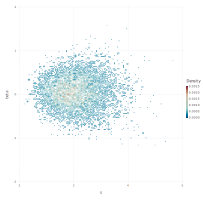

In [13]:
p = Mamba.plot(sim, :contour)
Mamba.draw(p, nrow = 1, ncol = 1)

### 10.3.2 階層ベイズモデルの事後分布推定と予測
$p(y \mid \beta, r)p(r \mid s)$を求める関数

In [14]:
function f_gaussian_binorm(alpha, x, size, fixed, sd)
   pdf(Binomial(size, logistic(fixed + alpha)), x) * pdf(Normal(0, sd), alpha)
end

f_gaussian_binorm (generic function with 1 method)

$p(y \mid \beta, s) = \int_{-\infty}^\infty p(y \mid \beta, r)p(r \mid s)dr$を求める関数. 
実際は$\int_{-10s}^{10s} p(y \mid \beta, r)p(r \mid s)dr$を求めている

In [15]:
function d_gaussian_binorm(x, fixed, sd)
    quadgk(y -> f_gaussian_binorm(y, x, 8, fixed, sd), -sd * 10, sd * 10)[1]
end

d_gaussian_binorm (generic function with 1 method)

各パスに対し, $y = 0, \ldots, 8$ に対して $p(y \mid \beta, s)$ を評価する.

In [20]:
posterior = map((x, y) -> d_gaussian_binorm.(0:8, x, y), sim[:, [:beta], :].value[:], sim[:, [:s], :].value[:])

5700-element Array{Array{Float64,1},1}:
 [0.218758, 0.114433, 0.0840964, 0.0721829, 0.0683941, 0.0705111, 0.0799748, 0.104875, 0.186775]  
 [0.217684, 0.101218, 0.0730643, 0.0629204, 0.0604223, 0.0637473, 0.0751491, 0.10636, 0.239434]   
 [0.267399, 0.0901415, 0.0605235, 0.0506823, 0.0481703, 0.0509376, 0.0611869, 0.0919296, 0.279029]
 [0.244887, 0.109133, 0.0768542, 0.064926, 0.0612506, 0.0634174, 0.0730596, 0.0998369, 0.206635]  
 [0.220491, 0.118914, 0.0876971, 0.0750665, 0.0707059, 0.0722311, 0.080757, 0.103124, 0.171013]   
 [0.247459, 0.103057, 0.0718046, 0.0606588, 0.0574951, 0.0600682, 0.0703041, 0.0992738, 0.22988]  
 [0.202347, 0.10845, 0.0810339, 0.0705131, 0.0676908, 0.0707764, 0.0816843, 0.109968, 0.207536]   
 [0.20543, 0.117201, 0.0883201, 0.0765118, 0.0726421, 0.0746252, 0.0837273, 0.1069, 0.174643]     
 [0.192399, 0.118144, 0.0912214, 0.079855, 0.0761237, 0.0781484, 0.0871108, 0.109175, 0.167822]   
 [0.260513, 0.125416, 0.0881707, 0.0732551, 0.067443, 0.0675416, 0.07

各パスに対して、$P(X=y)=p(y \mid \beta, s)\ \text{for}\ y = 0, \ldots, 8$というCategorical distributionから100個体のサンプリングを行い, $y$ごとに出現回数を数える. 横方向は各サンプリング, 縦方向は$y = 0, \ldots, 8$の出現回数に該当

In [17]:
population_samples = hcat(map(x -> fit(Histogram, rand(Distributions.Categorical(x), 100) .- 1, 0:9).weights, posterior)...)

9×5700 Array{Int64,2}:
 20  21  29  18  28  27  18  24  20  …  22  23  12  35  22  14  17  15  13
 15  13   7   8  17   6  17   4  15      8   8   7  10   7  11   7  12   9
  8   5   4   7   4   9   6   9   4     10  11   6   4   6  10   8   6  10
  5   7   7   9  10   5   9   3   8      4   6   5   8   8   8  10   6  10
  7   3   3   8   9   8   7  10   7      4   1   8   4   4  10   9   9   7
  8   8   6   7   2   5   1  11  13  …   9   6  11   3   3   7   6   8   7
 13   7   7   5   6   9  10   9   7      9   6  13   8  12   7  10  13  13
 10  10  10  12   8  11  11  13   7      9   9   6   6  10  12  14   7   3
 14  26  27  26  16  20  21  17  19     25  30  32  22  28  21  19  24  28

$y$毎に出現回数の2.5%, 50%, 97.5%点を計算

In [18]:
function quantile_sample(r)
    map(x -> quantile(population_samples[x, :], r), 1:9)
end
quantile_sample_0025 = quantile_sample(0.025)
quantile_sample_0975 = quantile_sample(0.975)
quantile_sample_median = quantile_sample(0.5)

9-element Array{Float64,1}:
 21.0
 10.0
  8.0
  6.0
  6.0
  7.0
  8.0
 11.0
 22.0

### 生存種子数の予測分布
各 $y$ における中央値, 及び95%区間の領域を表示する

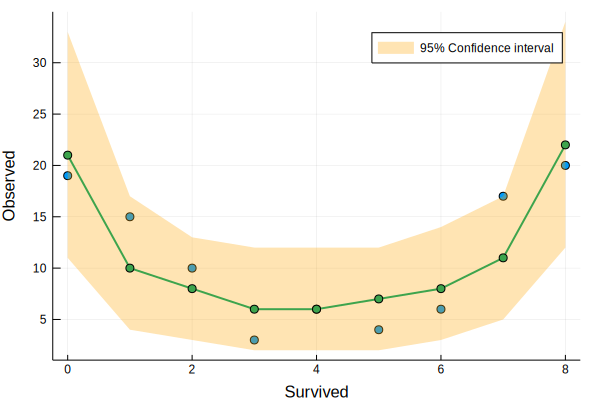

In [19]:
scatter(sort(unique(df.y)), counts(df.y), label = "")
Plots.plot!(0:8, quantile_sample_0025, lw = 0, 
    fillrange = quantile_sample_0975,
    fillalpha = 0.3, fillcolor = :orange,
    label = "95% Confidence interval")
Plots.plot!(0:8, quantile_sample_median, linewidth = 2, marker = 4, label = "",
            xlabel = "Survived", ylabel = "Observed")